# Adult Census Income Prediction

## Project Overview

This project analyzes the **UCI Adult Census Income dataset** to predict whether individuals earn more than $50K per year based on demographic and employment features.

### Objective
Build and compare multiple classification models to predict income levels, leveraging proper preprocessing, feature engineering, and hyperparameter optimization.

### Dataset
- **Source**: UCI Machine Learning Repository (via Kaggle)
- **Size**: 32,561 individuals with 15 features
- **Target**: Binary classification (≤50K vs >50K)
- **Features**: Age, education, occupation, marital status, capital gains/losses, hours worked, etc.

### Methodology
1. **Data Analysis**: Explore distributions, missing values, and correlations
2. **Preprocessing**: Handle missing values, encode categorical features, standardize numerics
3. **Baseline Models**: Compare Logistic Regression, Decision Trees, Random Forest, and XGBoost
4. **Feature Engineering**: Create domain-specific features (tested)
5. **Hyperparameter Tuning**: Optimize best performing model (XGBoost)
6. **Sample Weights**: Incorporate census weights (fnlwgt) for improved representation

### Key Results
- **Best Model**: XGBoost with sample weights
- **Final Accuracy**: 87.1%
- **AUC-ROC**: 0.921

# 1. Data Loading and Preparation

## 1.1 Download and Load Dataset

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# XGBoost
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report
)

# Project imports
import sys
from pathlib import Path

root = Path.cwd().parent
sys.path.append(str(root))

from src.helpers import compare_classification_models, evaluate_classification_model

<module 'src.helpers' from '/Users/boris.tsarev/MyProjects/ai-explore/src/helpers.py'>

In [150]:
from src.kaggle_utils import download_kaggle_dataset

# Download the dataset from Kaggle
download_kaggle_dataset('uciml/adult-census-income', str(root / Path("data/raw")))

# Load the dataset
data = pd.read_csv(str(root / Path("data/raw/adult-census-income/adult.csv")))
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### [Observations]

- Missing values marked as "?" in categorical values
- Target value "income" is categorical with 2 possible values

## 1.2 Train-Test Split and Feature Identification

In [151]:
from sklearn.model_selection import train_test_split

# Convert target variable to numeric
data["income"] = (data["income"] == '>50K').astype(int)

X = data.drop(columns=['income'])
y = data['income']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

income
<=50K    24720
>50K      7841
Name: count, dtype: int64
income
0    19775
1     6273
Name: count, dtype: int64
income
0    4945
1    1568
Name: count, dtype: int64
Numeric features: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Categorical features: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


# 2. Exploratory Data Analysis

In [118]:
# Amount of data 
print(f"Data shape: {data.shape}")

# Check for unknown values in categorical columns (sorted)
unknown_values = data[categorical_features].apply(lambda x: (x == '?').sum())
unknown_values = unknown_values[unknown_values > 0].sort_values(ascending=False)
print("\nUnknown values by column:")
print(unknown_values)

# Amount of different values in categorical columns (sorted)
unique_values = data[categorical_features].nunique().sort_values(ascending=False)
print("\nUnique values by column:")
print(unique_values)


Data shape: (32561, 15)

Unknown values by column:
occupation        1843
workclass         1836
native.country     583
dtype: int64

Unique values by column:
native.country    42
education         16
occupation        15
workclass          9
marital.status     7
relationship       6
race               5
sex                2
dtype: int64


### [Observations]

- Percentage of unknown values is not high. Should be imputed
- Some categories have a lot of unique values. Might be too much for OneHot imputer

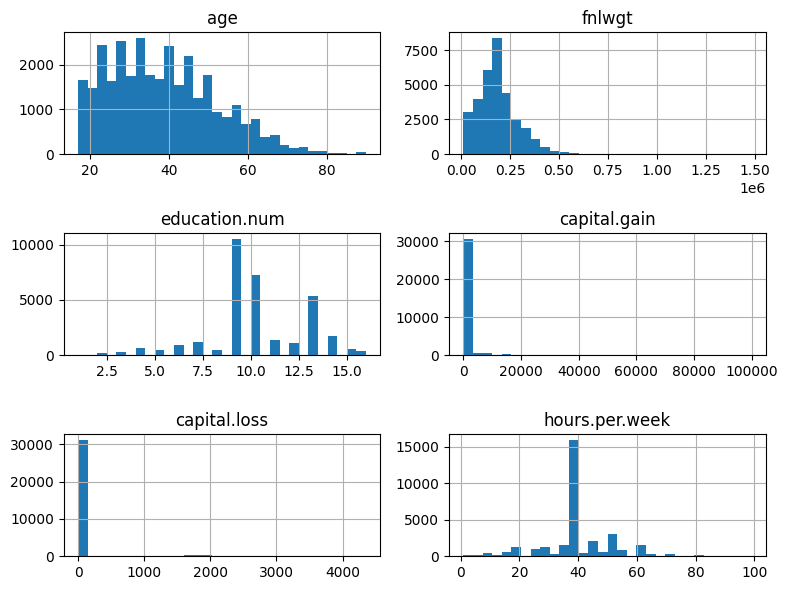

In [13]:
data.hist(bins=30, figsize=(8, 6))
plt.tight_layout()
plt.show()

In [153]:
# Explore numeric feature correlations
numeric_data = data.select_dtypes(include=['int64', 'float64'])
numeric_data.head()

corr_matrix = numeric_data.corr()
corr_matrix["income"].sort_values(ascending=False).drop("income")

education.num     0.335154
age               0.234037
hours.per.week    0.229689
capital.gain      0.223329
capital.loss      0.150526
fnlwgt           -0.009463
Name: income, dtype: float64

### [Observations]

- No high correlation with any numeric feature 
- Could be better with feature engineering later

# 3. Data Preprocessing Pipeline

## 3.1 Missing Data Imputation

In [48]:
from sklearn.impute import SimpleImputer

# Imputation for missing categorical values
categorical_imputer = SimpleImputer(strategy='most_frequent', missing_values='?')

## 3.2 Categorical Encoding

In [49]:
from sklearn.preprocessing import OneHotEncoder

# Categorical encoding
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## 3.3 Feature Scaling

In [51]:
from sklearn.preprocessing import StandardScaler

# Standardization for numeric features
numeric_scaler = StandardScaler()

## 3.4 Complete Preprocessing Pipeline

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('encoder', categorical_encoder)
        ]), categorical_features),
        ('num', numeric_scaler, numeric_features)
    ]
)

# 4. Baseline Model Comparison

## 4.1 Logistic Regression

In [119]:
from sklearn.linear_model import LogisticRegression

logistic_reg_model = LogisticRegression(max_iter=200, class_weight="balanced")

## 4.2 Decision Tree

In [113]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(random_state=42)

## 4.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=300, random_state=42)

## 4.4 XGBoost (Gradient Boosting)

In [106]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='error')


## 4.5 Voting Ensemble

In [ ]:
# Ensemble of models
from sklearn.ensemble import VotingClassifier

voting_ensemble = VotingClassifier(
    estimators=[
        ('logreg', logistic_reg_model),
        ('tree', decision_tree_model),
        ('rf', random_forest_model)
    ], voting='soft'
)

## 4.6 Model Comparison Results


  Logistic Regression
Cross-validation:  Acc=0.809 | F1=0.683
Test metrics:      Acc=0.805 | Prec=0.565 | Rec=0.837 | F1=0.674 | AUC=0.903

Classification Report:
              precision    recall  f1-score   support

           0      0.939     0.796     0.861      4945
           1      0.565     0.837     0.674      1568

    accuracy                          0.805      6513
   macro avg      0.752     0.816     0.768      6513
weighted avg      0.849     0.805     0.816      6513



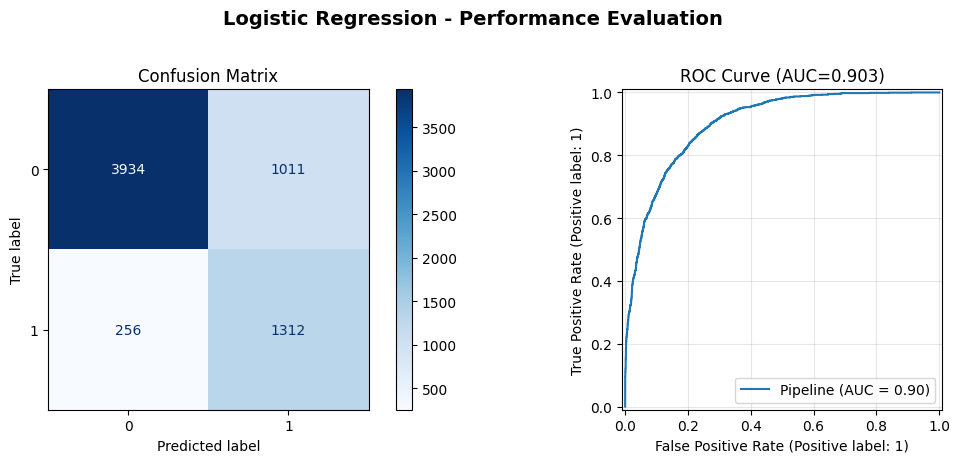


  Decision Tree
Cross-validation:  Acc=0.812 | F1=0.615
Test metrics:      Acc=0.814 | Prec=0.610 | Rec=0.633 | F1=0.621 | AUC=0.752

Classification Report:
              precision    recall  f1-score   support

           0      0.882     0.871     0.877      4945
           1      0.610     0.633     0.621      1568

    accuracy                          0.814      6513
   macro avg      0.746     0.752     0.749      6513
weighted avg      0.817     0.814     0.815      6513



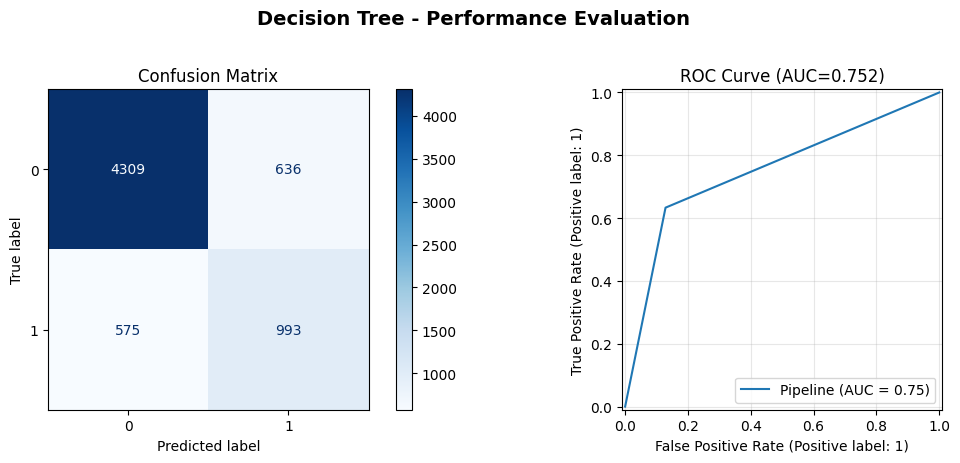


  Random Forest
Cross-validation:  Acc=0.852 | F1=0.672
Test metrics:      Acc=0.854 | Prec=0.730 | Rec=0.625 | F1=0.674 | AUC=0.901

Classification Report:
              precision    recall  f1-score   support

           0      0.886     0.927     0.906      4945
           1      0.730     0.625     0.674      1568

    accuracy                          0.854      6513
   macro avg      0.808     0.776     0.790      6513
weighted avg      0.849     0.854     0.850      6513



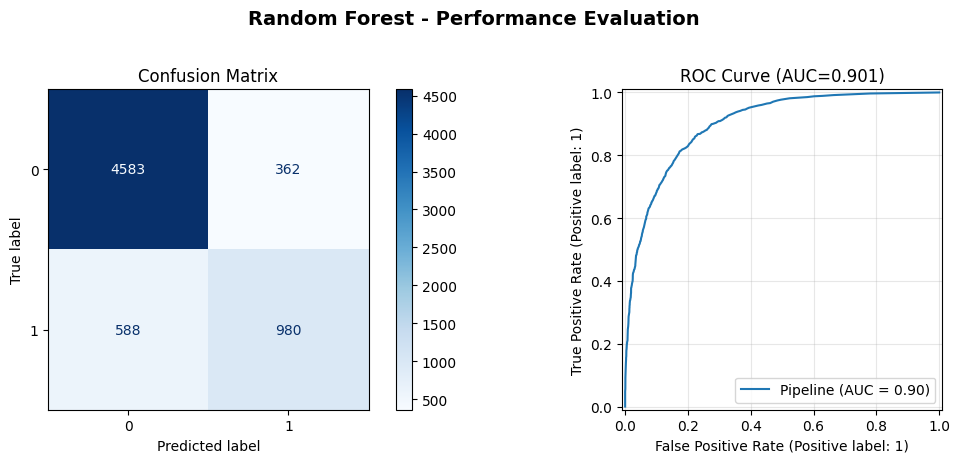


  Voting Ensemble
Cross-validation:  Acc=0.840 | F1=0.652
Test metrics:      Acc=0.840 | Prec=0.687 | Rec=0.617 | F1=0.650 | AUC=0.900

Classification Report:
              precision    recall  f1-score   support

           0      0.882     0.911     0.896      4945
           1      0.687     0.617     0.650      1568

    accuracy                          0.840      6513
   macro avg      0.784     0.764     0.773      6513
weighted avg      0.835     0.840     0.837      6513



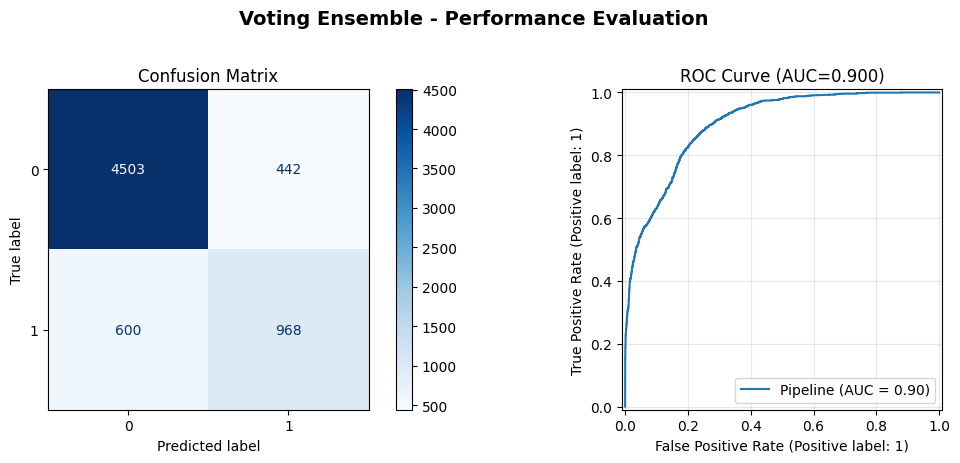


  XGBoost
Cross-validation:  Acc=0.870 | F1=0.711
Test metrics:      Acc=0.867 | Prec=0.766 | Rec=0.647 | F1=0.701 | AUC=0.922

Classification Report:
              precision    recall  f1-score   support

           0      0.893     0.938     0.915      4945
           1      0.766     0.647     0.701      1568

    accuracy                          0.867      6513
   macro avg      0.830     0.792     0.808      6513
weighted avg      0.863     0.867     0.863      6513



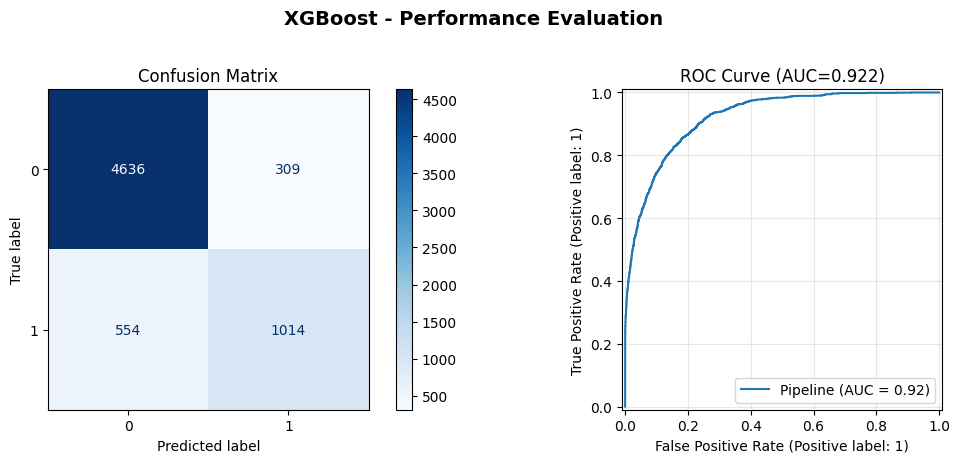


MODEL COMPARISON SUMMARY
                       cv_acc     cv_f1  test_acc  test_prec  test_rec   test_f1  test_auc
name                                                                                      
XGBoost              0.870124  0.710617  0.867496   0.766440  0.646684  0.701487  0.922232
Random Forest        0.852426  0.671843  0.854138   0.730253  0.625000  0.673540  0.901027
Voting Ensemble      0.839988  0.652431  0.840012   0.686525  0.617347  0.650101  0.900499
Decision Tree        0.812039  0.614531  0.814064   0.609576  0.633291  0.621207  0.752338
Logistic Regression  0.808968  0.682528  0.805466   0.564787  0.836735  0.674377  0.902774


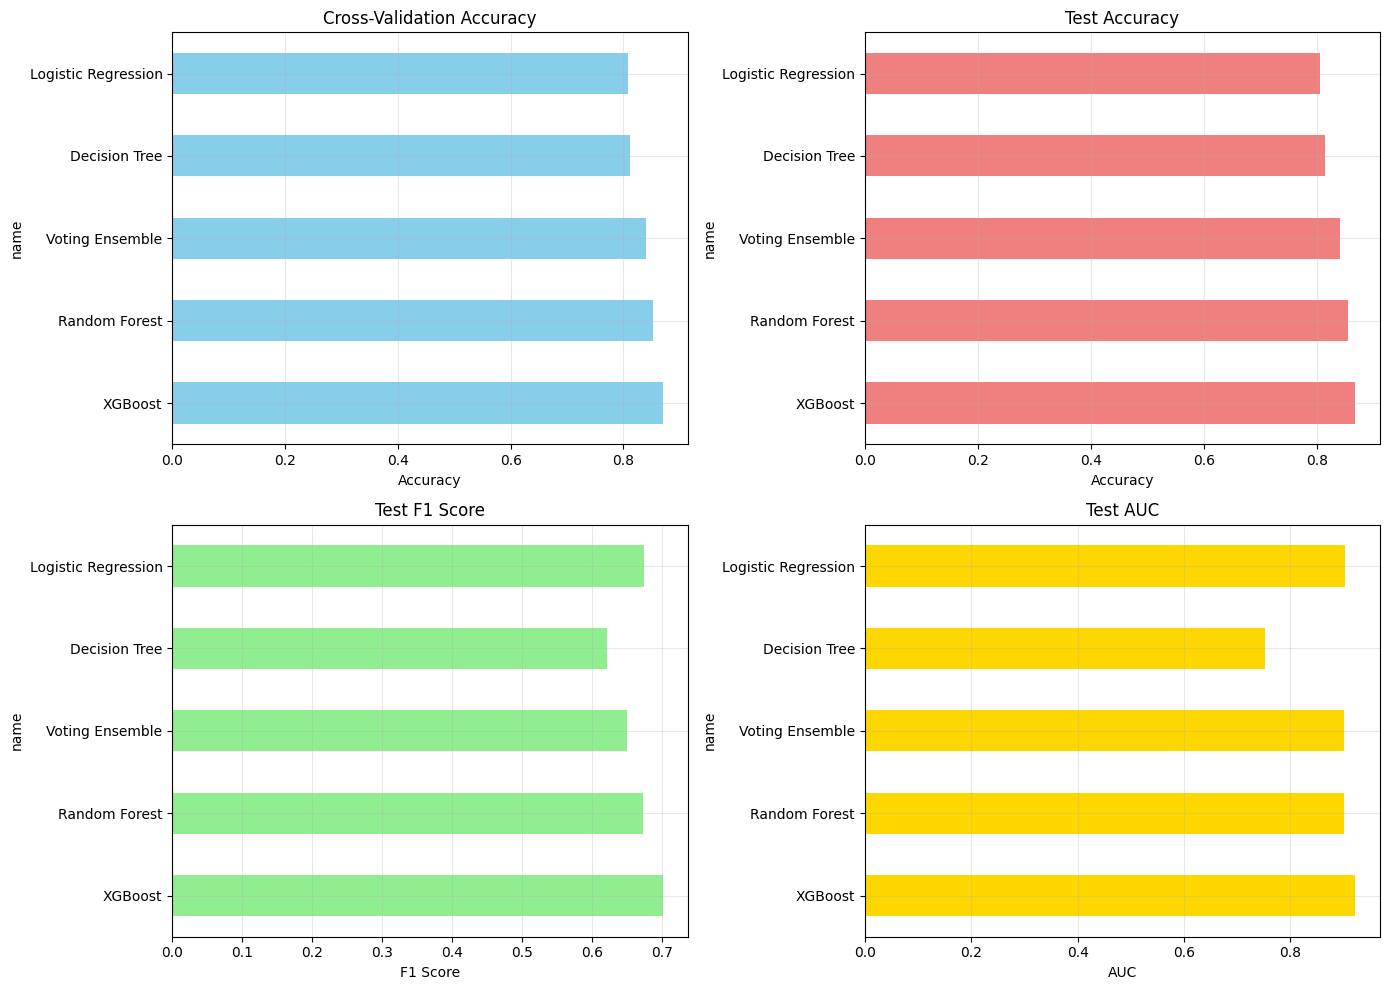


🏆 Best Model (by Test Accuracy): XGBoost
   Accuracy: 0.867
   F1 Score: 0.701
   AUC: 0.922


In [156]:
from src.helpers import compare_classification_models

models = {
    "Logistic Regression": logistic_reg_model,
    "Decision Tree": decision_tree_model,
    "Random Forest": random_forest_model,
    "Voting Ensemble": voting_ensemble,
    "XGBoost": xgb_model,
}

results_df = compare_classification_models(
    models, 
    preprocessor, 
    X_train, y_train, 
    X_valid, y_valid
)

### [Results]

**Logistic Regression**  
Cross-validation:  Acc=0.809 | F1=0.683  
Test metrics:      Acc=0.805 | Prec=0.565 | Rec=0.837 | F1=0.674 | AUC=0.903

**Decision Tree**  
Cross-validation:  Acc=0.812 | F1=0.615  
Test metrics:      Acc=0.814 | Prec=0.610 | Rec=0.633 | F1=0.621 | AUC=0.752

**Random Forest**  
Cross-validation:  Acc=0.852 | F1=0.672  
Test metrics:      Acc=0.854 | Prec=0.730 | Rec=0.625 | F1=0.674 | AUC=0.901

**Voting Ensemble**  
Cross-validation:  Acc=0.841 | F1=0.654  
Test metrics:      Acc=0.839 | Prec=0.683 | Rec=0.616 | F1=0.648 | AUC=0.900

**XGBoost**  
Cross-validation:  Acc=0.870 | F1=0.711  
Test metrics:      Acc=0.867 | Prec=0.766 | Rec=0.647 | F1=0.701 | AUC=0.922

🏆 Best Model (by Test Accuracy): XGBoost   
- Accuracy: 0.867  
- F1 Score: 0.701   
- AUC: 0.922

# 5. Feature Engineering Exploration

In [120]:
def create_age_features(df):
    df = df.copy()
    
    # Age groups based on career stages
    df['age_category'] = pd.cut(df['age'], 
                                bins=[0, 25, 35, 45, 55, 65, 100],
                                labels=['entry', 'early', 'mid', 'senior', 'late', 'retired'])
    
    # Working age population
    df['prime_working_age'] = ((df['age'] >= 25) & (df['age'] <= 55)).astype(int)
    
    # Retirement age
    df['retirement_age'] = (df['age'] >= 65).astype(int)
    
    # Age squared for non-linear relationships
    df['age_squared'] = df['age'] ** 2
    
    return df

In [121]:
def create_hours_features(df):
    df = df.copy()
    
    # Work schedule categories
    bins = [0, 20, 35, 45, 60, 100]
    labels = ['very_low', 'part', 'standard', 'extended', 'excessive']
    df['hours_category'] = pd.cut(df['hours.per.week'], bins=bins, labels=labels)
    
    # Unusual work patterns
    df['non_standard_hours'] = (
        (df['hours.per.week'] < 35) | (df['hours.per.week'] > 50)
    ).astype(int)
    
    # Weekly hours deviation from norm (40)
    df['hours_deviation'] = abs(df['hours.per.week'] - 40)
    
    return df

In [122]:
def create_financial_features(df):
    df = df.copy()
    
    # Net financial position
    df['net_capital'] = df['capital.gain'] - df['capital.loss']
    
    # Financial activity indicators
    df['has_investment_gain'] = (df['capital.gain'] > 0).astype(int)
    df['has_investment_loss'] = (df['capital.loss'] > 0).astype(int)
    df['financially_active'] = (
        (df['capital.gain'] > 0) | (df['capital.loss'] > 0)
    ).astype(int)
    
    # Investment success ratio (avoid division by zero)
    df['investment_ratio'] = np.where(
        df['capital.loss'] > 0,
        df['capital.gain'] / df['capital.loss'],
        df['capital.gain']
    )
    
    # Log transformations for skewed distributions
    df['log_capital_gain'] = np.log1p(df['capital.gain'])
    df['log_capital_loss'] = np.log1p(df['capital.loss'])
    
    return df

In [123]:
def create_education_features(df):
    df = df.copy()
    
    # Higher education indicator
    higher_ed = ['Bachelors', 'Masters', 'Doctorate', 'Prof-school']
    df['has_degree'] = df['education'].isin(higher_ed).astype(int)
    
    # Advanced degree
    advanced = ['Masters', 'Doctorate', 'Prof-school']
    df['advanced_degree'] = df['education'].isin(advanced).astype(int)
    
    # Some college or higher
    college_plus = higher_ed + ['Some-college', 'Assoc-voc', 'Assoc-acdm']
    df['college_educated'] = df['education'].isin(college_plus).astype(int)
    
    # Education-age interaction
    df['education_age_ratio'] = df['education.num'] / (df['age'] + 1)
    
    return df

In [125]:
def create_occupation_features(df):
    df = df.copy()
    
    # Professional occupations
    professional = ['Prof-specialty', 'Exec-managerial', 'Tech-support']
    df['is_professional'] = df['occupation'].isin(professional).astype(int)
    
    # Private sector indicator
    df['private_sector'] = (df['workclass'] == 'Private').astype(int)
    
    # Self-employed
    self_employed = ['Self-emp-not-inc', 'Self-emp-inc']
    df['self_employed'] = df['workclass'].isin(self_employed).astype(int)
    
    # Government worker
    govt = ['Federal-gov', 'State-gov', 'Local-gov']
    df['government_worker'] = df['workclass'].isin(govt).astype(int)
    
    return df

In [126]:
def create_demographic_features(df):
    df = df.copy()
    
    # Marital status simplification
    married = ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']
    df['is_married'] = df['marital.status'].isin(married).astype(int)
    
    # Never married
    df['never_married'] = (df['marital.status'] == 'Never-married').astype(int)
    
    # Gender-marital interaction
    df['married_male'] = (df['is_married'] & (df['sex'] == 'Male')).astype(int)
    df['married_female'] = (df['is_married'] & (df['sex'] == 'Female')).astype(int)
    
    # US citizen
    df['is_us_citizen'] = (df['native.country'] == 'United-States').astype(int)
    
    return df

In [127]:
def create_composite_features(df):
    df = df.copy()
    
    # Income potential score
    df['income_potential'] = (
        df['education.num'] * 0.3 +
        (df['age'] / 100) * 0.2 +
        (df['hours.per.week'] / 100) * 0.2 +
        df['has_investment_gain'] * 0.3
    )
    
    # Work-life balance score
    df['work_life_score'] = np.where(
        df['hours.per.week'] <= 40,
        1.0,
        1.0 - ((df['hours.per.week'] - 40) / 100)
    )
    
    # Career stability indicator
    df['career_stable'] = (
        (df['age'] >= 30) & 
        (df['hours.per.week'] >= 35) & 
        df['is_married']
    ).astype(int)
    
    return df


  Logistic Regression
Cross-validation:  Acc=0.820 | F1=0.696
Test metrics:      Acc=0.815 | Prec=0.579 | Rec=0.843 | F1=0.686 | AUC=0.909

Classification Report:
              precision    recall  f1-score   support

           0      0.942     0.805     0.868      4945
           1      0.579     0.843     0.686      1568

    accuracy                          0.815      6513
   macro avg      0.760     0.824     0.777      6513
weighted avg      0.854     0.815     0.825      6513



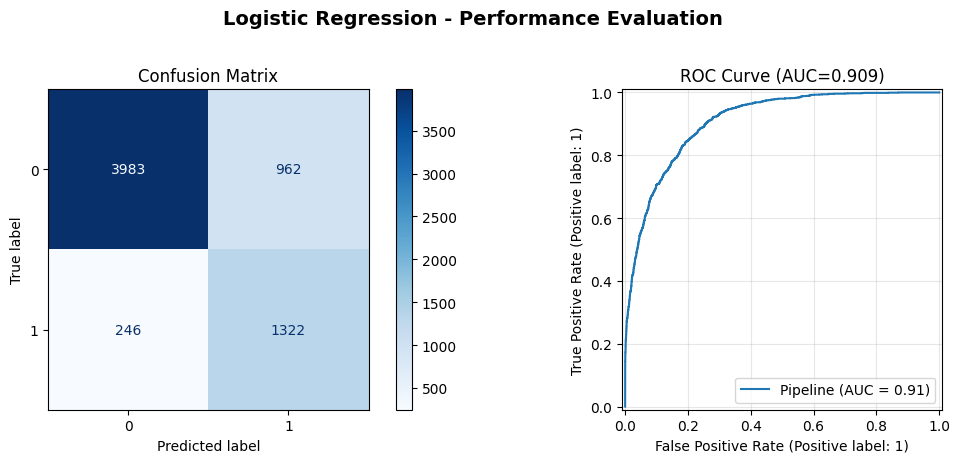


  Decision Tree
Cross-validation:  Acc=0.815 | F1=0.622
Test metrics:      Acc=0.811 | Prec=0.604 | Rec=0.622 | F1=0.613 | AUC=0.746

Classification Report:
              precision    recall  f1-score   support

           0      0.879     0.871     0.875      4945
           1      0.604     0.622     0.613      1568

    accuracy                          0.811      6513
   macro avg      0.742     0.746     0.744      6513
weighted avg      0.813     0.811     0.812      6513



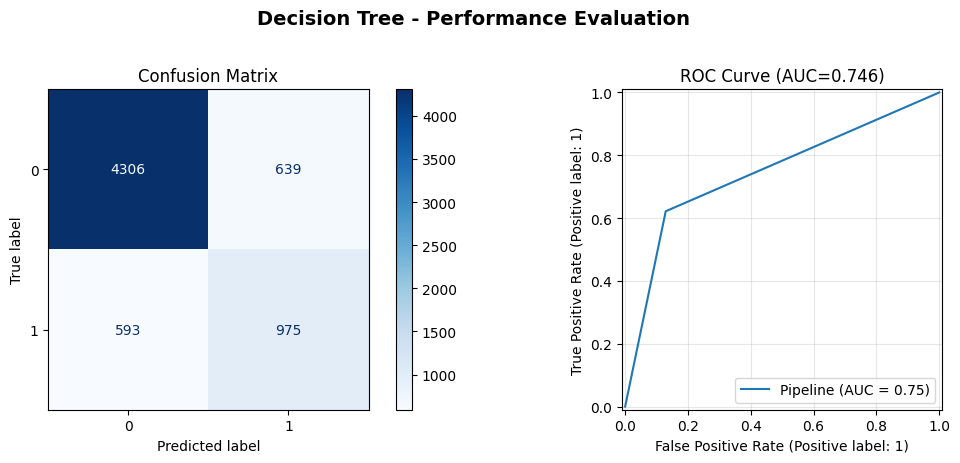


  Random Forest
Cross-validation:  Acc=0.854 | F1=0.673
Test metrics:      Acc=0.855 | Prec=0.735 | Rec=0.620 | F1=0.673 | AUC=0.903

Classification Report:
              precision    recall  f1-score   support

           0      0.885     0.929     0.907      4945
           1      0.735     0.620     0.673      1568

    accuracy                          0.855      6513
   macro avg      0.810     0.775     0.790      6513
weighted avg      0.849     0.855     0.850      6513



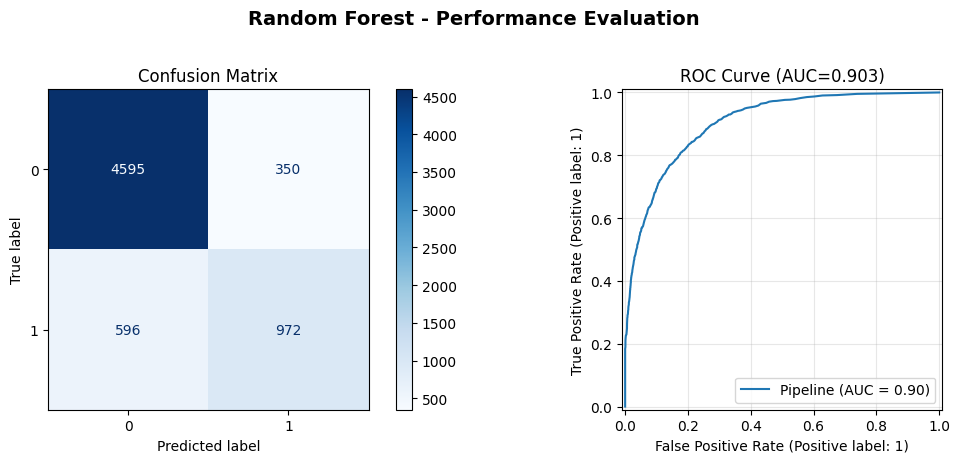

/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/boris.tsarev/MyProjects/ai-explore/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https


  Voting Ensemble
Cross-validation:  Acc=0.843 | F1=0.658
Test metrics:      Acc=0.842 | Prec=0.685 | Rec=0.635 | F1=0.659 | AUC=0.903

Classification Report:
              precision    recall  f1-score   support

           0      0.887     0.908     0.897      4945
           1      0.685     0.635     0.659      1568

    accuracy                          0.842      6513
   macro avg      0.786     0.771     0.778      6513
weighted avg      0.838     0.842     0.840      6513



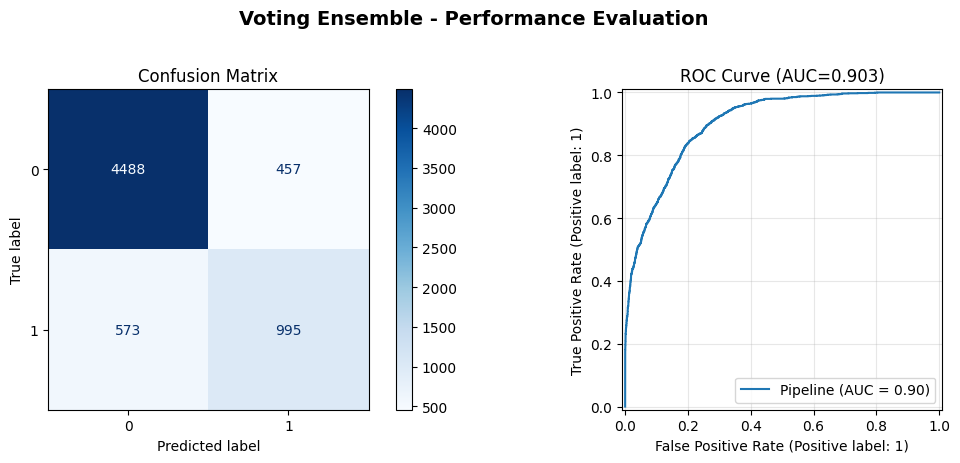


  XGBoost
Cross-validation:  Acc=0.869 | F1=0.709
Test metrics:      Acc=0.867 | Prec=0.764 | Rec=0.647 | F1=0.701 | AUC=0.922

Classification Report:
              precision    recall  f1-score   support

           0      0.893     0.937     0.914      4945
           1      0.764     0.647     0.701      1568

    accuracy                          0.867      6513
   macro avg      0.829     0.792     0.807      6513
weighted avg      0.862     0.867     0.863      6513



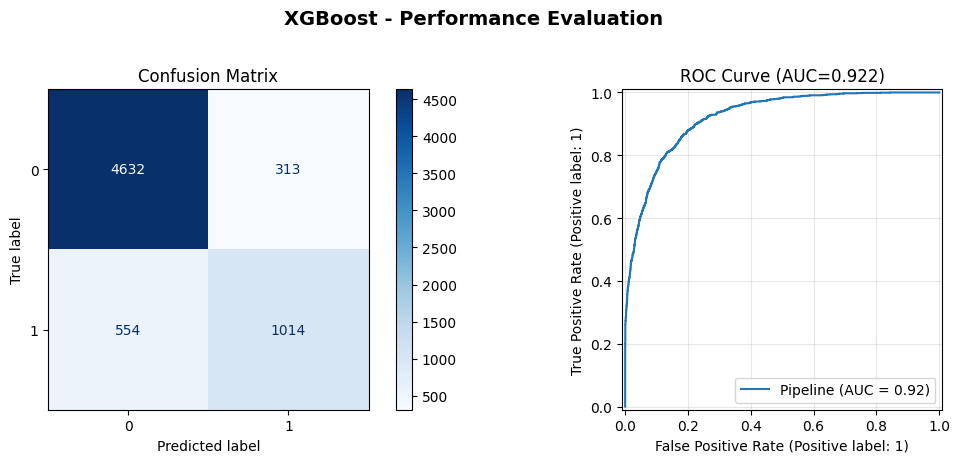


MODEL COMPARISON SUMMARY
                       cv_acc     cv_f1  test_acc  test_prec  test_rec   test_f1  test_auc
name                                                                                      
XGBoost              0.869011  0.708962  0.866882   0.764130  0.646684  0.700518  0.921862
Random Forest        0.853731  0.673255  0.854752   0.735250  0.619898  0.672664  0.903373
Voting Ensemble      0.842713  0.657976  0.841855   0.685262  0.634566  0.658940  0.903362
Logistic Regression  0.819602  0.696423  0.814525   0.578809  0.843112  0.686397  0.909240
Decision Tree        0.814688  0.621682  0.810840   0.604089  0.621811  0.612822  0.746295


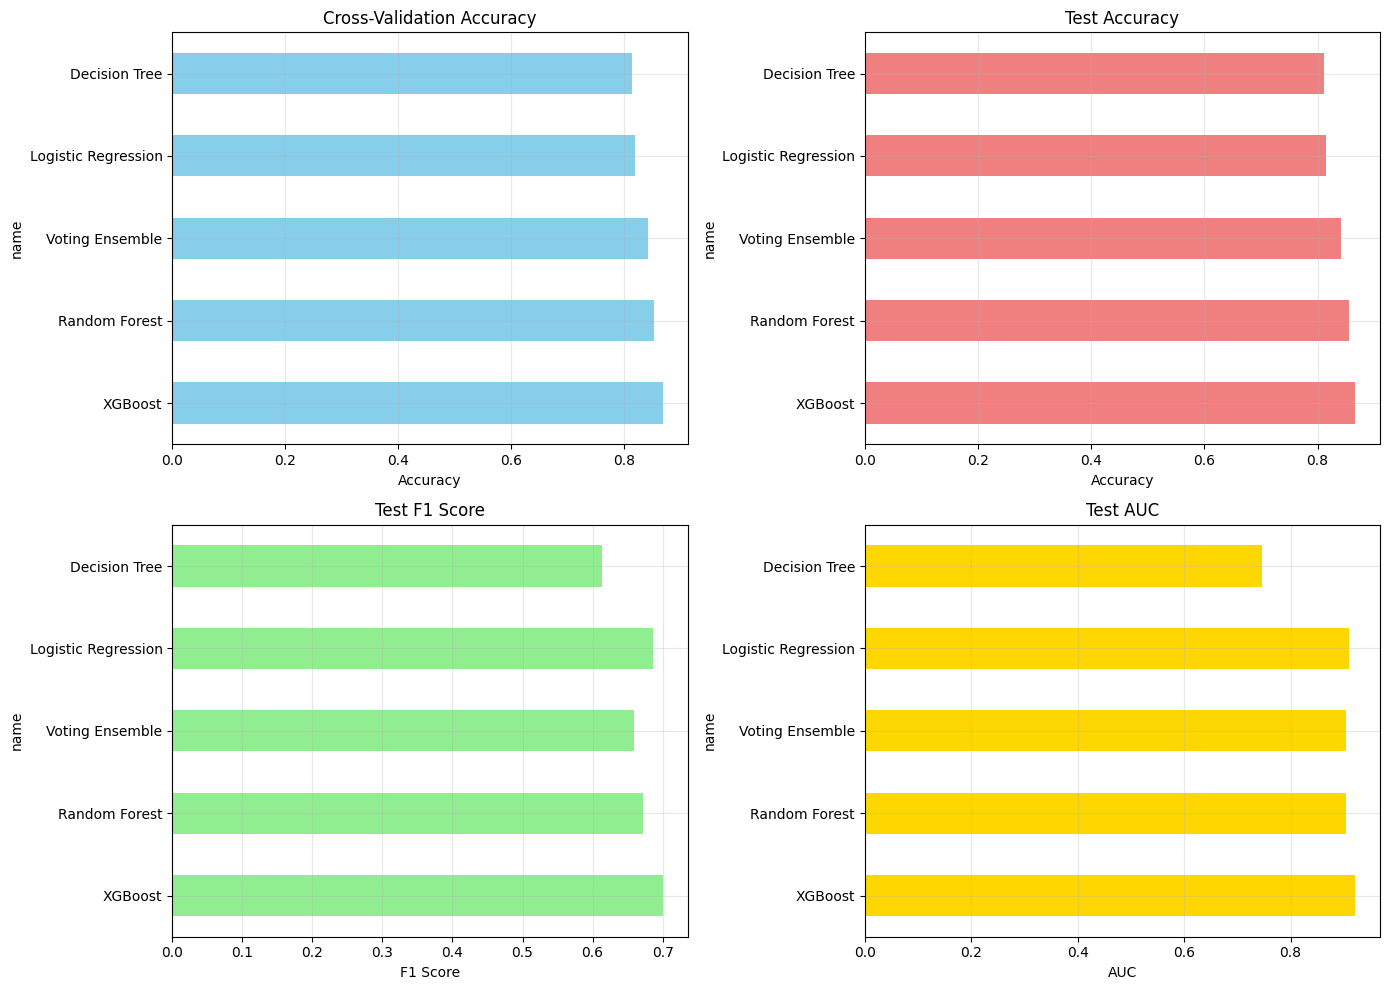


🏆 Best Model (by Test Accuracy): XGBoost
   Accuracy: 0.867
   F1 Score: 0.701
   AUC: 0.922


In [160]:
from src.helpers import evaluate_classification_model

def engineer_features(df):
    """Apply all feature engineering transformations"""
    df = create_age_features(df)
    df = create_hours_features(df)
    df = create_financial_features(df)
    df = create_education_features(df)
    df = create_occupation_features(df)
    df = create_demographic_features(df)
    df = create_composite_features(df)
    
    return df

# Apply to your data
X_train_engineered = engineer_features(X_train)
X_valid_engineered = engineer_features(X_valid)

numeric_features_eng = X_train_engineered.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_eng = X_train_engineered.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor_eng = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent', missing_values='?')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features_eng),
        ('num', StandardScaler(), numeric_features_eng)
    ]
)

# Train and compare models on engineered features
results_eng_df = compare_classification_models(
    models, 
    preprocessor_eng, 
    X_train_engineered, y_train, 
    X_valid_engineered, y_valid
)

# Tuning Hyperparameters

In [161]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_tuned = XGBClassifier(eval_metric='logloss', random_state=42, base_score=0.5)
grid_search = GridSearchCV(
    xgb_tuned, 
    param_grid, 
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Use original features
full_pipeline_tuning = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', grid_search)
])

full_pipeline_tuning.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}
Best CV score: 0.873


## Train the model with best hyperparams


  XGBoost Tuned
Cross-validation:  Acc=0.873 | F1=0.712
Test metrics:      Acc=0.870 | Prec=0.776 | Rec=0.644 | F1=0.704 | AUC=0.923

Classification Report:
              precision    recall  f1-score   support

           0      0.893     0.941     0.916      4945
           1      0.776     0.644     0.704      1568

    accuracy                          0.870      6513
   macro avg      0.835     0.793     0.810      6513
weighted avg      0.865     0.870     0.865      6513



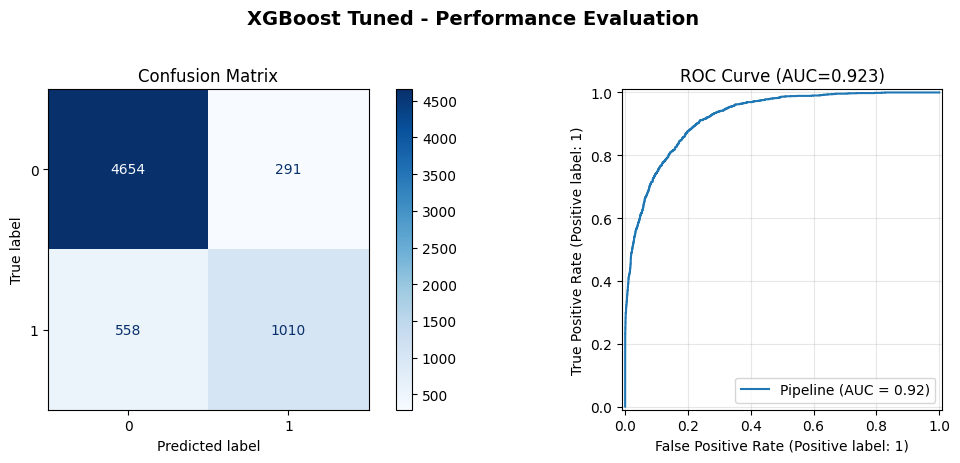

{'name': 'XGBoost Tuned',
 'cv_acc': np.float64(0.8728116514713756),
 'cv_f1': np.float64(0.7123779213153364),
 'test_acc': 0.8696453247351451,
 'test_prec': 0.776325903151422,
 'test_rec': 0.6441326530612245,
 'test_f1': 0.7040780759846637,
 'test_auc': 0.922710078723097}

In [163]:
# Use best hyperparameters to evaluate on validation set
best_xgb = grid_search.best_estimator_
evaluate_classification_model("XGBoost Tuned",
    best_xgb, 
    preprocessor, 
    X_train, y_train, 
    X_valid, y_valid
)

# Feature Importance


 Top 15 Most Important Features:
                          feature  importance
marital.status_Married-civ-spouse    0.400993
                    education.num    0.059379
                     capital.gain    0.044140
         occupation_Other-service    0.032194
           relationship_Own-child    0.031748
       occupation_Exec-managerial    0.027126
                     capital.loss    0.020120
       occupation_Farming-fishing    0.013843
                              age    0.013020
     occupation_Handlers-cleaners    0.012531
                education_Masters    0.011441
                   hours.per.week    0.011379
          occupation_Tech-support    0.011101
     occupation_Machine-op-inspct    0.010457
            workclass_Federal-gov    0.009895


<Figure size 1000x600 with 0 Axes>

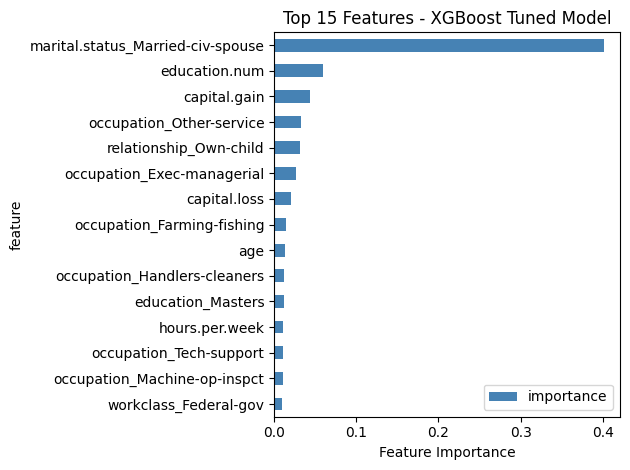

In [164]:
# Analyze what the tuned model learned
best_xgb = grid_search.best_estimator_

# Get feature names after one-hot encoding
feature_names_cat = list(preprocessor.named_transformers_['cat']
                         .named_steps['encoder']
                         .get_feature_names_out(categorical_features))
feature_names_all = feature_names_cat + numeric_features

# Create importance dataframe
importances_df = pd.DataFrame({
    'feature': feature_names_all,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 15 Most Important Features:")
print(importances_df.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
importances_df.head(15).plot(x='feature', y='importance', kind='barh', color='steelblue')
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - XGBoost Tuned Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Use weighted features

In [166]:
# Remove fnlwgt from features and use it as sample weight instead
X_train_weighted = X_train.drop(columns=['fnlwgt'])
X_valid_weighted = X_valid.drop(columns=['fnlwgt'])

# Extract weights
sample_weights_train = X_train['fnlwgt'].values

# Update feature lists (remove fnlwgt)
numeric_features_weighted = [f for f in numeric_features if f != 'fnlwgt']

# Update preprocessor
preprocessor_weighted = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent', missing_values='?')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features),
        ('num', StandardScaler(), numeric_features_weighted)
    ]
)

# Create XGBoost with sample weights using best hyperparameters
xgb_weighted = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    base_score=0.5,
    **grid_search.best_params_
)

# Use evaluate_classification_model with sample weights
# Note: We need to pass sample_weight through fit_params
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Monkey-patch to add sample weights (workaround for evaluate_classification_model)
# Alternative: Evaluate manually with similar structure
full_pipeline_weighted = Pipeline([
    ('preprocessor', preprocessor_weighted),
    ('classifier', xgb_weighted)
])

# Fit with sample weights
full_pipeline_weighted.fit(
    X_train_weighted, 
    y_train,
    classifier__sample_weight=sample_weights_train
)

# Evaluate manually (similar to evaluate_classification_model)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

y_pred = full_pipeline_weighted.predict(X_valid_weighted)
y_pred_proba = full_pipeline_weighted.predict_proba(X_valid_weighted)[:, 1]

print("=" * 70)
print("  XGBoost with Sample Weights (fnlwgt)")
print("=" * 70)
print(f"Test metrics:      Acc={accuracy_score(y_valid, y_pred):.3f} | "
      f"Prec={precision_score(y_valid, y_pred):.3f} | "
      f"Rec={recall_score(y_valid, y_pred):.3f} | "
      f"F1={f1_score(y_valid, y_pred):.3f} | "
      f"AUC={roc_auc_score(y_valid, y_pred_proba):.3f}")

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

  XGBoost with Sample Weights (fnlwgt)
Test metrics:      Acc=0.871 | Prec=0.766 | Rec=0.666 | F1=0.713 | AUC=0.921

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4945
           1       0.77      0.67      0.71      1568

    accuracy                           0.87      6513
   macro avg       0.83      0.80      0.81      6513
weighted avg       0.87      0.87      0.87      6513

